## Pre-Processing_Dataset_1.py
Ana Cismaru

In [17]:
import os
import numpy as np
import mne

This notebook uses the Sleep Cassette Study (153 recordings in .edf format) and Data from Sleep EDF Expanded Dataset
Link: https://physionet.org/content/sleep-edfx/1.0.0/

<b> Upload Data </b>

Input: String that contains folder name of folder with PSG.edf files


Output: list of MNE Raw Objects

In [18]:
data_folder = "sample_psg_data"

def upload_raw(data_folder):
    mne_raw = []

    for path in os.listdir(data_folder):
        if path.endswith(".edf"):
            full_path = os.path.join(data_folder, path)
            raw = mne.io.read_raw_edf(full_path, preload=True)
            mne_raw.append(raw)
    return mne_raw

mne_raw = upload_raw(data_folder)

Extracting EDF parameters from /Users/anacismaru/mlab/eeg-ssl/sample_psg_data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...
Extracting EDF parameters from /Users/anacismaru/mlab/eeg-ssl/sample_psg_data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...
Extracting EDF parameters from /Users/anacismaru/mlab/eeg-ssl/sample_psg_data/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8549999  =      0.000 ... 85499.990 secs...
Extracting EDF parameters from /Users/anacismaru/mlab/eeg-ssl/sample_psg_data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


<b> Plot upload </b>

Effective window size : 20.480 (s)


<ipython-input-19-34896292633e>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mne_raw[2].plot_psd()


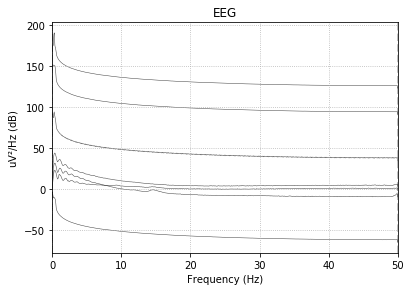

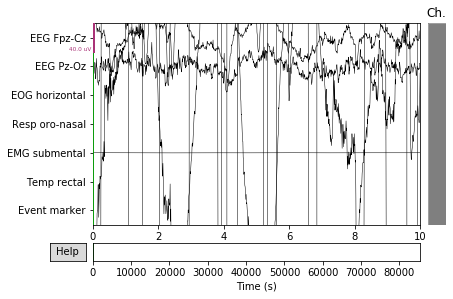

check


In [19]:
mne_raw[2].plot_psd()
mne_raw[2].plot()
print("check")

<b> Remove Non EEG Channels </b>

Input: list of MNE Raw Objects

Output: list of MNE Raw Objects with only EEG channels

In [20]:
#For sleep edf, manual extraction because mne.pick_types isn't working

def remove_sleepEDF(mne_raw):
    mne_eeg = []
    for point in mne_raw:
        mne_eeg.append(point.pick_channels(["EEG Fpz-Cz", "EEG Pz-Oz"]))
    return mne_eeg

mne_eeg = remove_sleepEDF(mne_raw)

In [21]:
#In general
def remove(mne_raw):
    mne_eeg_gen = []
    for point in mne_raw:
        mne_eeg_gen.append(point.pick_types(eeg = True))
    return mne_eeg_gen

<b> Filter 30 HZ 4th-order FIR lowpass filter </b>

Input: list of MNE Raw Objects with only EEG chaneels

Output: list of filtered MNE Raw Objects

<font color='red'>Filter order is wrong!!</font> 

In [22]:
def filter(mne_eeg):
    for point in mne_eeg:
        point.filter(l_freq=None,
                h_freq=30,
                picks = ["EEG Fpz-Cz", "EEG Pz-Oz"],
                filter_length = 45,
                method = "fir"
                )
mne_filtered = filter(mne_eeg)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter par

<b> Pickle Objects </b>

Input: A list of preprocessed MNE Objects.
    
Output: A pickled object.

In [23]:
import pickle

with open('data1.pkl', 'wb') as f:
    pickle.dump(mne_filtered, f)

<b> Label Engineering: merge labels 3 and 4 </b>

Input: path to folder containing Hypnogram label files (.edf format)

Output: list of MNE Annotation Objects

In [95]:
data_folder = "sample_hypnogram_data"

def upload_labels(data_folder):
    labels = []
    for path in os.listdir(data_folder):
        if path.endswith(".edf"):
            full_path = os.path.join(data_folder, path)
            label = mne.read_annotations(full_path)
            labels.append(label)
    return labels

labels = upload_labels(data_folder)

Input: list of MNE Annotation Objects

Output: list of MNE Annotation Objects with merged labels 3 and 4 --> now label 3

In [97]:
def merge(labels):
    
    def merge_labels(label):
        new_label = np.array([])
        for stage in label:
            if stage == "Sleep stage 4":
                new_label = np.append(new_label, "Sleep stage 3")
            else:
                new_label = np.append(new_label, stage)
        return new_label
    
    for label in labels:
        label.description = merge_labels(label.description)
    
merge(labels)        